In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.autograd import Variable
import cv2
import shutil
from tqdm import tqdm

BATCH_SIZE = 121
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 128
D_HIDDEN = 64
EPOCH_NUM = 500
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 0.0005
seed = 1

CUDA = torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
if CUDA:
    print(f"CUDA version: {torch.version.cuda}\n")

torch.cuda.manual_seed(seed)

device = torch.device("cuda" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.1.2
CUDA version: 12.1



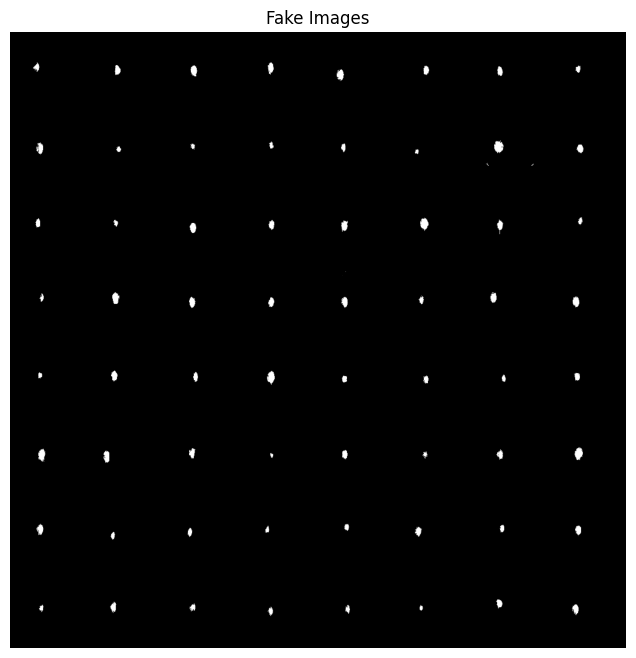

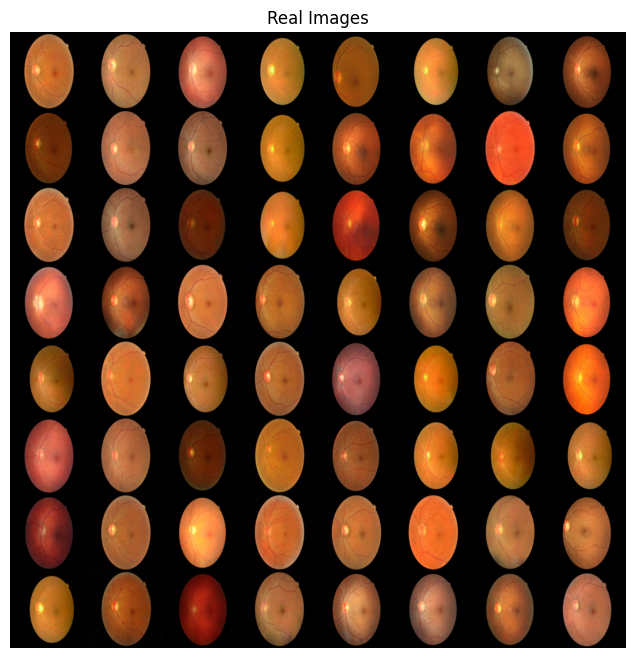

In [2]:
##Generator Input Data##
transform = transforms.Compose([transforms.ToTensor()])
class vector_Dataset():
    def __init__(self,transform=None):
        self.files=os.listdir('/kaggle/input/gan-data-847/optic')
        #print(self.files)
        self.file_name=[]
        for file in self.files:
            basename, extension = os.path.splitext(file)
            self.file_name.append(basename)
            
    def __len__(self):
        return(len(self.files))
    
    def __getitem__(self,idx):
        optic=cv2.imread(f'/kaggle/input/gan-data-847/optic/{self.file_name[idx]}.png')
        optic=cv2.resize(optic,(128,128))
        optic=cv2.cvtColor(optic, cv2.COLOR_BGR2GRAY)
        #plt.imshow(optic)
        #plt.show()
        optic=transform(optic)#.to(device)
        
        return optic

in_dataset=vector_Dataset()

# Dataloader
G_inputs = torch.utils.data.DataLoader(in_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)    

"""# Plot some training images
input_batch = next(iter(G_inputs))
print(input_batch.shape)
print('Input_BATCH_SIZE: ',len(input_batch))
#print(input_batch)
print('Image Size: ',input_batch[0].shape)
#print('After loading: ',input_batch[1].shape)
#print('After loading: ',input_batch[2].shape)
#print('After loading: ',input_batch[3].shape)

for i in range(len(input_batch)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(input_batch[i].permute(1,2,0).detach().cpu().numpy(), cmap="gray") #change to proper RGB nd.Array
plt.show()"""

# Plot some training images
Data=next(iter(G_inputs))
#print(Data)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(Data.to(device)[:64], nrow=8, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()



##Discriminator Traing Data##
"""transform = transforms.Compose([transforms.ToTensor()])
class training_Dataset():
    def __init__(self,transform=None):
        root_dir=r'/kaggle/input/gan-test-data/Image_DATA/GAN_input/64x64/original'
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
            
    def __len__(self):
        return(len(self.image_paths))
    
    def __getitem__(self,idx):
        optic=cv2.imread(self.image_paths[idx])
        optic=cv2.resize(optic,(64,64))
        optic=cv2.cvtColor(optic, cv2.COLOR_BGR2RGB)
        optic=transform(optic)#.to(device)
        
        return optic

train_dataset=training_Dataset()

# Dataloader
D_inputs = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)"""

# Data preprocessing
training_dataset = dset.ImageFolder(root=r'/kaggle/input/gan-data-847/custom_data',
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                     ]))

# Dataloader
D_inputs = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, drop_last=False,
                                         shuffle=False, num_workers=4)

real_list=[]
for i, data in enumerate(D_inputs, 0):
    #print(i)
    real_list.append(data[0])
    
# Plot some training images
Data=next(iter(D_inputs))
#print(Data[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(Data[0].to(device)[:64], nrow=8, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [3]:
print(len(real_list))
real_list[0].shape
print(real_list[0].dtype)

7
torch.float32


In [4]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class downsampler(nn.Module):
    # initializers
    def __init__(self, d=4):
        super(downsampler, self).__init__()
        self.conv1 = nn.Conv2d(1, d,kernel_size=65, stride=1, padding=0)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2,kernel_size=33, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4,kernel_size=17, stride=1, padding=0)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8,kernel_size=16, stride=1, padding=0)
        self.linear=nn.Linear(32,100).to(device)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        print('shape after Layer1: ',x.shape)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        print('shape after Layer2: ',x.shape)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        print('shape after Layer3: ',x.shape)
        #x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        #print('shape after Layer4: ',x.shape)
        x = self.conv4(x)
        print('shape after Layer4: ',x.shape) 
        x = self.linear(torch.flatten(x, start_dim=1))#, end_dim=2
        print('shape after Linear Layer: ',x.shape)        

        return x
    
class generator(nn.Module):
    # initializers
    def __init__(self, d=G_HIDDEN):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(Z_DIM, d*16, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*16)
        self.deconv2 = nn.ConvTranspose2d(d*16, d*8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*8)
        self.deconv3 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*4)
        self.deconv4 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d*2)
        self.deconv5 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d)
        self.deconv6 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
        # 1x1 to 4x4 to 8x8 to 16x16 to 32x32 to 64x64 to 128x128

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.relu(self.deconv5_bn(self.deconv5(x)))
        x = F.tanh(self.deconv6(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=D_HIDDEN):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, d*16, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d*16)
        self.conv6 = nn.Conv2d(d*16, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
        x = F.sigmoid(self.conv6(x))

        return x

# Create the generator
netG = generator()
# netG = nn.DataParallel(netG)
netG.to(device)
print(netG)

# Create the discriminator
netD = discriminator()
# netD = nn.DataParallel(netD)
netD.to(device)
print(netD)

#create Downsampler instance
Dsmplr = downsampler()
Dsmplr.to(device)
print(Dsmplr)

input_vectors = []
G_input_data = []

for i,data in enumerate(G_inputs,0):
    datapoint = data.to(device)
    G_input_data.append(datapoint)
    print('\nDatapoint size: ',datapoint.shape)
    b_size = datapoint.size(0)
    print('Batch size: ',b_size)
    print('original shape: ',datapoint.shape)
    tensor=Dsmplr.forward(datapoint)
    print('New Tensor size: ',tensor.shape)
    # Reshape to (b_size, 100, 1, 1)
    tensor = tensor.view(b_size, 100, 1, 1)
    print('New Input Noise Size: ',tensor.shape)
    input_vectors.append(tensor)

print('\nTotal input Batches: ',len(input_vectors))
print('\nTotal input Batches: ', G_input_data[-1].shape)
#print(tensor)

generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv5_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv6): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2)

In [5]:
def display_images(G_input_data, img_list):
    # Plot some fake images
    optic_batch = G_input_data[-1]
    fake_batch = img_list[-1] #next(iter(img_list))
    #print(fake_batch.shape)
    for i in range(4):
        fake=np.transpose(vutils.make_grid(fake_batch.to(device)[i], nrow=10, padding=2, normalize=True).cpu(),(1,2,0))
        optic=np.transpose(vutils.make_grid(optic_batch.to(device)[i], nrow=10, padding=2, normalize=True).cpu(),(1,2,0))
        # Create a figure with 1 row and 2 columns of subplots
        f, (ax1, ax2) = plt.subplots(1, 2)

        # Display the first image in the first subplot
        ax1.imshow(optic)
        ax1.set_title('Optic Image')
        ax1.axis('off')  # Turn off axis for a cleaner look

        # Display the second image in the second subplot
        ax2.imshow(fake)
        ax2.set_title('Generated Image')
        ax2.axis('off')  # Turn off axis for a cleaner look

        # Show the figure
        plt.show()

In [6]:
!pip list | grep -E 'torchmetrics | fidelity'
#!conda install -c conda-forge torch-fidelity
#!pip install torchmetrics[image] torch-fidelity
!pip show torch-fidelity

torchmetrics                             1.3.2


In [7]:
from torchmetrics.image.fid import FrechetInceptionDistance

print('Done')
fid = FrechetInceptionDistance(feature=768, reset_real_features=False, normalize=True).to(device)

def FID_evaluation(reals,fakes):
    Real_images = reals
    Fake_images = fakes
    fid.update(Real_images, real = True)
    fid.update(Fake_images, real = False)
    score = fid.compute().item()
    fid.reset()
    return score

Done


ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

In [ ]:
# Training

# Create batch of latent vectors that I will use to visualize the progression of the generator
#viz_noise = noise#torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
#noise_list = []

if __name__=='__main__':
    print("Starting Training Loop...")
    netG.load_state_dict(torch.load('/kaggle/input/gan-major-final-weights-1400/generator.weight')) #,map_location=torch.device('cpu')
    netD.load_state_dict(torch.load('/kaggle/input/gan-major-final-weights-1400/discriminator.weight')) #,map_location=torch.device('cpu')
    #netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))#,map_location=torch.device('cpu')
    #netD.load_state_dict(torch.load('/kaggle/working/discriminator.weight'))#,map_location=torch.device('cpu')
    netG.train()
    netD.train()
    for epoch in range(EPOCH_NUM):
        for i, data in enumerate(D_inputs, 0):
            # (1) Update the discriminator with real data
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            #print(b_size)

            label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
            #print('real_label: ',label.shape)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            #print('output_label: ',output.shape)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            # (2) Update the discriminator with fake data
            
            # Generate batch of latent vectors
            #noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
            noise = input_vectors[i]
            
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(FAKE_LABEL)
            #print('fake_label: ',label.shape)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            # (3) Update the generator with fake data
            netG.zero_grad()
            label.fill_(REAL_LABEL)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
#             errG.backward(retain_graph=True)
            errG.backward(retain_graph=True)
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            
            with torch.no_grad():
                fake = netG(noise).detach().cpu()
                #print('generated size: ',fake.shape)
            img_list.append(fake)
            #print('done')

            # Output training stats
            if ((i+1)%len(D_inputs)) == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch+1, EPOCH_NUM, i, len(D_inputs),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                #print('Batch: ',i+1)
                real_img = real_list[i].to(device)#.detach().cpu()#.to(device)
                fake_img = netG(noise).to(device)#.detach().cpu()
                #print(fake_img.dtype)
                FID_score = FID_evaluation(real_img,fake_img)
                print('FID_score: ',FID_score)
                if epoch==0:
                    best_FID=FID_score
                    
                if (FID_score<best_FID):
                    print("........Saving.......")
                    best_FID=FID_score
                    %mkdir /kaggle/working/{epoch+1}
                    torch.save(netG.state_dict(), f'/kaggle/working/{epoch+1}/generator.weight')
                    torch.save(netD.state_dict(), f'/kaggle/working/{epoch+1}/discriminator.weight')
                

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
        if ((epoch+1)%5==0):
            avg_G_Loss=sum(G_losses[-5:])/5
            avg_D_Loss=sum(D_losses[-5:])/5
            if avg_G_Loss>=20 or avg_D_Loss>=5 or avg_D_Loss==0:
                print('Exited')
                break
            
        if ((epoch+1)%100==0):
            display_images(G_input_data,img_list)

In [ ]:
#plot loss graph
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Generate image
def save_image(fake):
    %mkdir /kaggle/working/Generated_Batch
    print('Generated Image Size: ',fake[0].shape)
    for i,genrated_image in enumerate(fake):
        #print(i)
        genrated_image = np.moveaxis(genrated_image, 0, -1)
        #print(genrated_image.shape)
        m = np.min(genrated_image)
        M = np.max(genrated_image)
        genrated_image = (genrated_image-m)/(M-m)
        genrated_image = 255*genrated_image
        genrated_image = np.array(genrated_image, dtype='uint8')
        #plt.imshow(genrated_image)
        #plt.show()
        plt.imsave(f'/kaggle/working/Generated_Batch/{i}.png', genrated_image)

        source_folder = '/kaggle/working/Generated_Batch'
        output_path = '/kaggle/working/'
        shutil.make_archive('Output', 'zip', source_folder)

def display_image(dataloader,str):
    # Plot some training images
    Data=dataloader #next(iter(dataloader))
    #print(Data.shape)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"{str} Images")
    plt.imshow(np.transpose(vutils.make_grid(Data[:64],nrow=8, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

def display(Data):
    print(Data.shape)
    Data=next(iter(G_inputs))
    #print(Data)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("optic disk")
    plt.imshow(np.transpose(vutils.make_grid(Data.to(device)[:64], nrow=8, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

    
def generate_Image(noise, str):
    #netG.to(device)
    netG = generator()
    netG.to(device)
    netG.eval()
    netG.load_state_dict(torch.load('/kaggle/input/gan-final-weights-1400/generator.weight'))
    #netG.load_state_dict(torch.load('/kaggle/working/200/generator.weight'))
    #netG.load_state_dict(torch.load('/kaggle/input/weights128-3000/generator.weight'))
    
    #noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
    with torch.no_grad():
        #print(noise.shape)
        fake = netG(noise).detach().cpu()#.numpy()
    
    #save_image(netG(noise).detach().cpu().numpy())        
    display_image(fake, str)#

In [ ]:
#generate_Image(noise, 'Noise 1')
generate_Image(input_vectors[2], 'Noise 2')
# display()
'''for i in range(10):
    generate_Image(input_vectors[1], 'generated')'''

In [ ]:
#%lsmagic
#%rm -rf /kaggle/working/*
#%tar -cf outputs.tar /kaggle/working/Generated_Batch
#%apt update && sudo apt install zip